## Loading and preparing Data

In [1]:
import pandas as pd

# Carica il dataset
file_path = 'data\dataset_for_topic_labeling.xlsx'
df = pd.read_excel(file_path)
df_filtered = df[df['topic'].notna()]
df_filtered = df_filtered[df_filtered['reply'].isna()]
df_filtered = df_filtered[df_filtered['topic'] != '3. Studyplan']
df_filtered = df_filtered[df_filtered['text'].notna()]

df_filtered.reset_index(drop=True, inplace=True)

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score, confusion_matrix
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from transformers import DataCollatorWithPadding
from datasets import Dataset, load_metric
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\asus-zen\anaconda3\envs\BERT\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Splitting in Training and Testing (80:20)

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import DistilBertTokenizer

# Rimuovi le righe con valori NaN nella colonna 'text'
df_filtered = df_filtered[df_filtered['text'].notna()]

# Seleziona le colonne di testo e i topic
X = df_filtered['text']
y = df_filtered['topic']

# Dividi il dataset in set di addestramento e di test in modo stratificato
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [4]:
print('Train set:' + str(len(X_train)))
print('Test set:' + str(len(X_test)))

Train set:1169
Test set:293


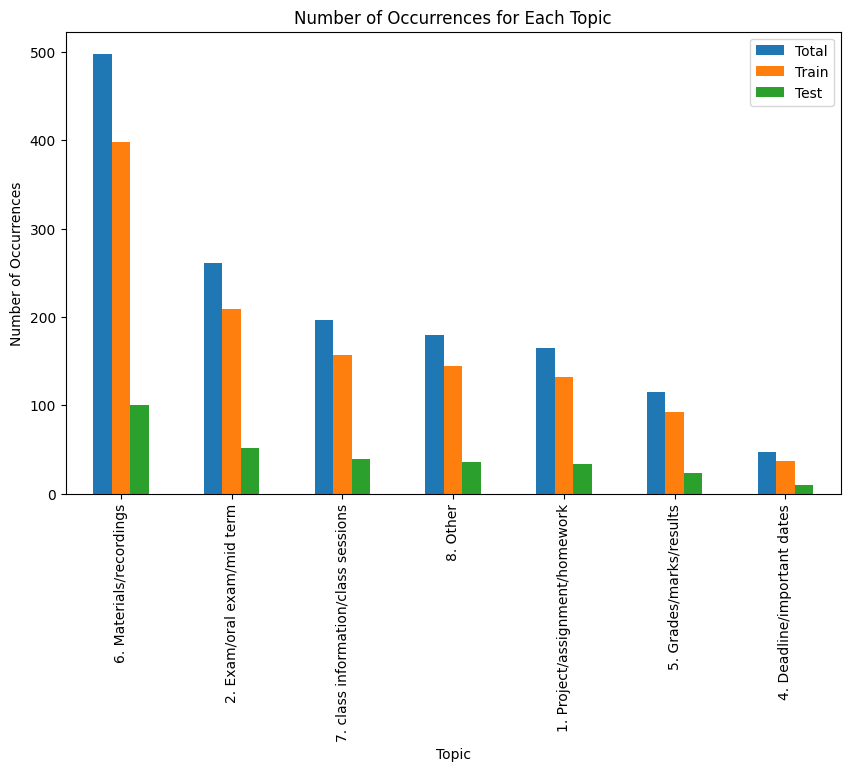

In [5]:
import pandas as pd
import matplotlib.pyplot as plt


# Conta le occorrenze dei topic nel dataset completo, nel train set e nel test set
topic_counts = df_filtered['topic'].value_counts()
topic_counts_train = y_train.value_counts()
topic_counts_test = y_test.value_counts()

# Crea un dataframe per facilitare la visualizzazione
topic_counts_df = pd.DataFrame({
    'Total': topic_counts,
    'Train': topic_counts_train,
    'Test': topic_counts_test
}).fillna(0)

# Visualizza le occorrenze dei topic su un grafico
ax = topic_counts_df.plot(kind='bar', figsize=(10, 6))
plt.title('Number of Occurrences for Each Topic')
plt.xlabel('Topic')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=90)  # Ruota le etichette di 90 gradi per scriverle in verticale
plt.show()


In [6]:
# Codifica i topic in numeri
label2id = {label: idx for idx, label in enumerate(y.unique())}
id2label = {idx: label for label, idx in label2id.items()}
y = y.map(label2id)

# Dividi il dataset in set di addestramento e di test in modo stratificato
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
# Crea dataset per Hugging Face
train_dataset = Dataset.from_dict({'text': X_train.tolist(), 'label': y_train.tolist()})
test_dataset = Dataset.from_dict({'text': X_test.tolist(), 'label': y_test.tolist()})

# Inizializza il tokenizer DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenizza il dataset
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=512)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Imposta il formato per PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

c:\Users\asus-zen\anaconda3\envs\BERT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\asus-zen\anaconda3\envs\BERT\lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\asus-zen\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python

## Training the model

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from datasets import Dataset, load_metric
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding, EarlyStoppingCallback
import torch


In [11]:

# Create dataset for Hugging Face
train_dataset = Dataset.from_dict({'text': X_train.tolist(), 'label': y_train.tolist()})
test_dataset = Dataset.from_dict({'text': X_test.tolist(), 'label': y_test.tolist()})

# Initialize the DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=512)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set the format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Initialize the DistilBERT model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label2id))

# Set the data collator
data_collator = DataCollatorWithPadding(tokenizer)

# Early stopping callback
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=5)

# Setting training arguments with TensorBoard logging
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    logging_strategy='steps',
    logging_steps=10,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=30,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
    save_total_limit=2,
    report_to="tensorboard",  # Use TensorBoard for logging
    logging_dir='./logs',  # Directory for TensorBoard logs
)

accuracy_metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[early_stopping_callback],
    compute_metrics=compute_metrics
)

trainer.train()

Map:   0%|          | 0/1169 [00:00<?, ? examples/s]

Map:   0%|          | 0/293 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-11-81eb61565243>:54: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_metric = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argu

Epoch,Training Loss,Validation Loss,Accuracy
1,1.267800,1.218570,0.610922
2,0.915500,1.054154,0.641638
3,0.595500,1.041147,0.665529
4,0.350800,1.180889,0.682594
5,0.285100,1.407831,0.655290
6,0.031600,1.455903,0.713311
7,0.023800,1.619968,0.675768
8,0.019400,1.725884,0.689420
9,0.003400,1.861055,0.675768
10,0.001800,1.880586,0.692833


TrainOutput(global_step=1617, training_loss=0.3516681201061396, metrics={'train_runtime': 694.4247, 'train_samples_per_second': 50.502, 'train_steps_per_second': 6.351, 'total_flos': 1703550167768064.0, 'train_loss': 0.3516681201061396, 'epoch': 11.0})

In [21]:
# Save the final model manually
model.save_pretrained('./final_model_early stopping_2')
tokenizer.save_pretrained('./final_model_early_stopping_2')

('./final_model_early_stopping_2/tokenizer_config.json',
 './final_model_early_stopping_2/special_tokens_map.json',
 './final_model_early_stopping_2/vocab.txt',
 './final_model_early_stopping_2/added_tokens.json')

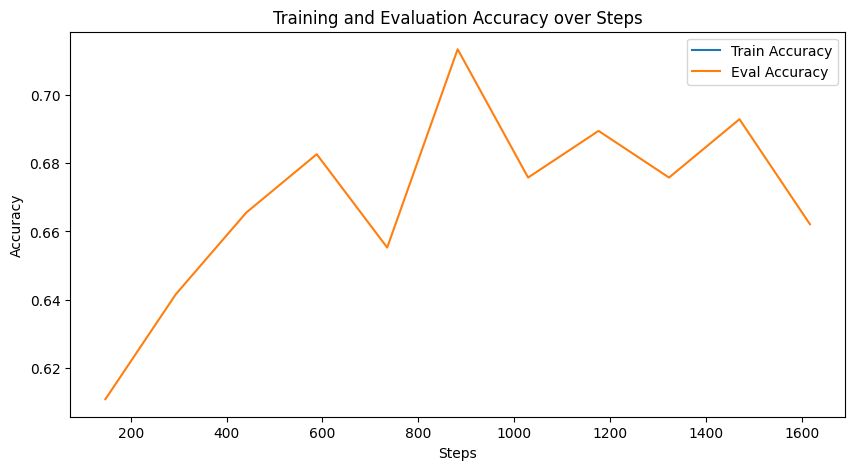

In [14]:
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Read TensorBoard logs
event_acc = EventAccumulator('./logs')
event_acc.Reload()

# Extract scalar logs for accuracy
train_accuracy_steps = []
train_accuracy_values = []
eval_accuracy_steps = []
eval_accuracy_values = []

for tag in event_acc.Tags()['scalars']:
    if 'accuracy' in tag:
        events = event_acc.Scalars(tag)
        for event in events:
            if 'eval' in tag:
                eval_accuracy_steps.append(event.step)
                eval_accuracy_values.append(event.value)
            elif 'train' in tag:
                train_accuracy_steps.append(event.step)
                train_accuracy_values.append(event.value)

# Plot the training and evaluation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_steps, train_accuracy_values, label='Train Accuracy')
plt.plot(eval_accuracy_steps, eval_accuracy_values, label='Eval Accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.title('Training and Evaluation Accuracy over Steps')
plt.legend()
plt.show()



## To load the model

In [15]:
# Create dataset for Hugging Face
train_dataset = Dataset.from_dict({'text': X_train.tolist(), 'label': y_train.tolist()})
test_dataset = Dataset.from_dict({'text': X_test.tolist(), 'label': y_test.tolist()})

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=512)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set the format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Initialize the DistilBERT model
model = DistilBertForSequenceClassification.from_pretrained('classification_models\DistilBERT\distilBERT_model', num_labels=len(label2id))

# Initialize the DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('classification_models\DistilBERT\distilBERT_tokenizer')

# Set the data collator
data_collator = DataCollatorWithPadding(tokenizer)

# Early stopping callback
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=5)

# Setting training arguments with TensorBoard logging
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    logging_strategy='steps',
    logging_steps=10,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=30,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
    save_total_limit=2,
    report_to="tensorboard",  # Use TensorBoard for logging
    logging_dir='./logs',  # Directory for TensorBoard logs
)

accuracy_metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[early_stopping_callback],
    compute_metrics=compute_metrics
)

Map: 100%|██████████| 293/293 [00:00<00:00, 714.45 examples/s]
c:\Users\asus-zen\anaconda3\envs\BERT\lib\site-packages\datasets\load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


## To evaluate the model

In [16]:

# Valuta il modello sul test set
predictions = trainer.predict(test_dataset)
y_pred_test = predictions.predictions.argmax(axis=-1)

# Decodifica le etichette
y_test_decoded = y_test.map(id2label)
y_pred_test_decoded = pd.Series(y_pred_test).map(id2label)

# Ottieni il classification report per il test set
report_test = classification_report(y_test_decoded, y_pred_test_decoded, output_dict=True)

# Calcola le medie complessive per il test set
overall_precision_test = precision_recall_fscore_support(y_test_decoded, y_pred_test_decoded, average='macro')[0]
overall_recall_test = precision_recall_fscore_support(y_test_decoded, y_pred_test_decoded, average='macro')[1]
overall_f1_test = precision_recall_fscore_support(y_test_decoded, y_pred_test_decoded, average='macro')[2]
accuracy_test = accuracy_score(y_test_decoded, y_pred_test_decoded)

# Stampa i risultati per il test set
print(f"Test Set - Overall Precision: {overall_precision_test}")
print(f"Test Set - Overall Recall: {overall_recall_test}")
print(f"Test Set - Overall F1-score: {overall_f1_test}")
print(f"Test Set - Accuracy: {accuracy_test}")
print(classification_report(y_test_decoded, y_pred_test_decoded))

100%|██████████| 37/37 [07:15<00:00, 11.76s/it]


Test Set - Overall Precision: 0.7348156487475374
Test Set - Overall Recall: 0.6496907922994879
Test Set - Overall F1-score: 0.6788494393191067
Test Set - Accuracy: 0.7133105802047781
                                     precision    recall  f1-score   support

     1. Project/assignment/homework       0.77      0.70      0.73        33
         2. Exam/oral exam/mid term       0.60      0.75      0.67        52
        4. Deadline/important dates       0.80      0.40      0.53        10
            5. Grades/marks/results       0.84      0.70      0.76        23
            6. Materials/recordings       0.75      0.83      0.79       100
7. class information/class sessions       0.65      0.56      0.60        39
                           8. Other       0.73      0.61      0.67        36

                           accuracy                           0.71       293
                          macro avg       0.73      0.65      0.68       293
                       weighted avg       0.7

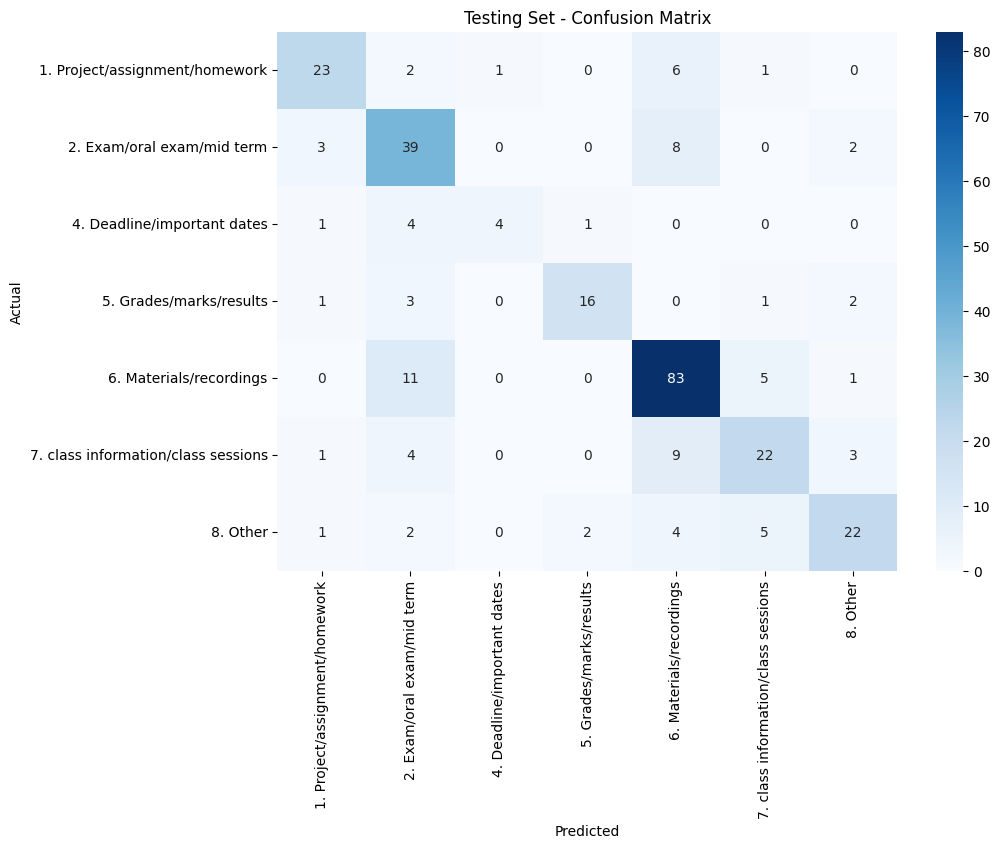

In [16]:
# Calcola la confusion matrix per il test set
conf_matrix_test = confusion_matrix(y_test_decoded, y_pred_test_decoded)


# Visualizza la confusion matrix per il training set
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=label2id.keys(), yticklabels=label2id.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Testing Set - Confusion Matrix')
plt.show()

In [17]:
# Valuta il modello sul training set
predictions_train = trainer.predict(train_dataset)
y_pred_train = predictions_train.predictions.argmax(axis=-1)

# Decodifica le etichette per il training set
y_train_decoded = y_train.map(id2label)
y_pred_train_decoded = pd.Series(y_pred_train).map(id2label)

# Ottieni il classification report per il training set
report_train = classification_report(y_train_decoded, y_pred_train_decoded, output_dict=True)

# Calcola le medie complessive per il training set
overall_precision_train = precision_recall_fscore_support(y_train_decoded, y_pred_train_decoded, average='macro')[0]
overall_recall_train = precision_recall_fscore_support(y_train_decoded, y_pred_train_decoded, average='macro')[1]
overall_f1_train = precision_recall_fscore_support(y_train_decoded, y_pred_train_decoded, average='macro')[2]
accuracy_train = accuracy_score(y_train_decoded, y_pred_train_decoded)

# Stampa i risultati per il training set
print(f"Training Set - Overall Precision: {overall_precision_train}")
print(f"Training Set - Overall Recall: {overall_recall_train}")
print(f"Training Set - Overall F1-score: {overall_f1_train}")
print(f"Training Set - Accuracy: {accuracy_train}")
print(classification_report(y_train_decoded, y_pred_train_decoded))


Training Set - Overall Precision: 0.9928459376736685
Training Set - Overall Recall: 0.9806005995873578
Training Set - Overall F1-score: 0.986440596377393
Training Set - Accuracy: 0.9905902480752781
                                     precision    recall  f1-score   support

     1. Project/assignment/homework       1.00      0.98      0.99       132
         2. Exam/oral exam/mid term       0.99      1.00      0.99       209
        4. Deadline/important dates       1.00      0.92      0.96        37
            5. Grades/marks/results       1.00      1.00      1.00        92
            6. Materials/recordings       0.99      1.00      0.99       398
7. class information/class sessions       0.98      0.99      0.99       157
                           8. Other       0.99      0.98      0.99       144

                           accuracy                           0.99      1169
                          macro avg       0.99      0.98      0.99      1169
                       weighte

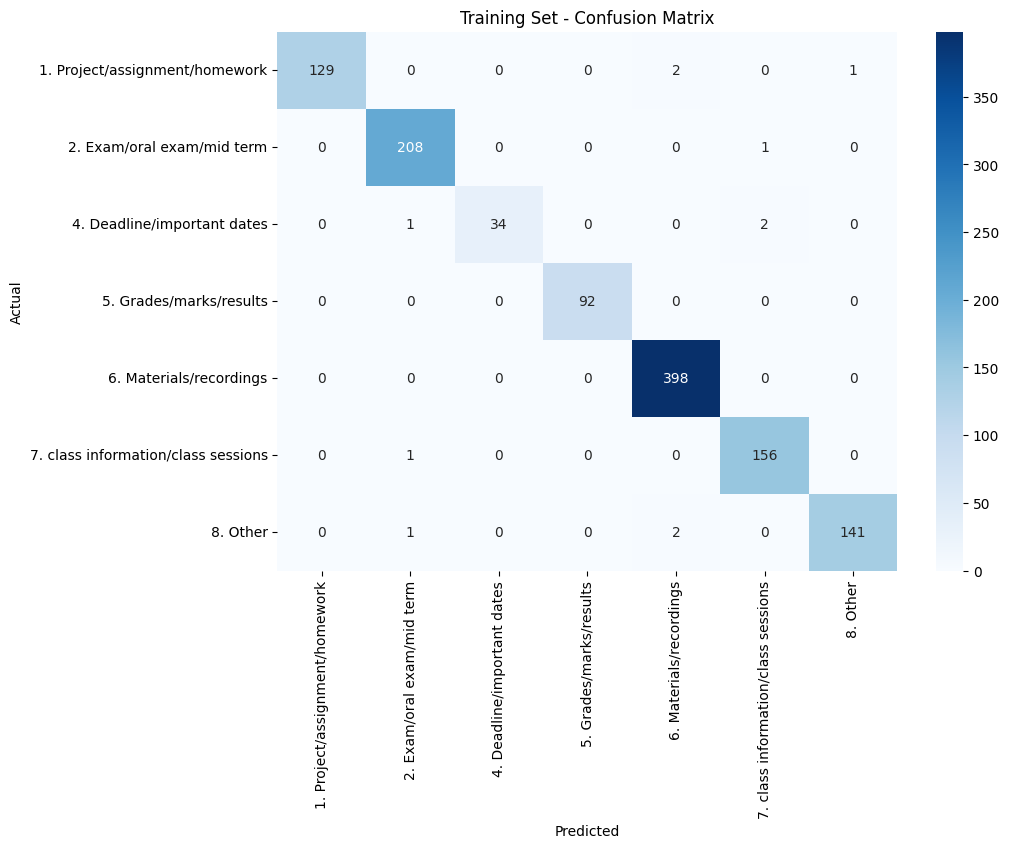

In [18]:
# Calcola la confusion matrix per il training set
conf_matrix_train = confusion_matrix(y_train_decoded, y_pred_train_decoded)

# Visualizza la confusion matrix per il training set
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=label2id.keys(), yticklabels=label2id.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Training Set - Confusion Matrix')
plt.show()